# Import libraries & data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install squarify
import squarify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/FinalProject/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Đọc sheet 'ecommerce retail'
ecommerce_retail = pd.read_excel(f'{base_path}/ecommerce retail.xlsx', sheet_name='ecommerce retail')
# Đọc sheet 'Segmentation'
segmentation_data = pd.read_excel(f'{base_path}/ecommerce retail.xlsx', sheet_name='Segmentation')


#PART 1: EDA

##EDA ecommerce retail.xlsx

- ***Duplicate:*** 5268 rows -> xóa các dòng duplicate
- ***Missing data:***
  + CustomerID(0.27%) -> xóa các dòng thiếu dữ liệu vì gây ảnh hưởng tới mô hình RFM
  + Description(25.16%) -> chỉ là tên sản phẩm không ảnh hưởng tới mô hình RFM -> giữ nguyên
- ***Incorrect data types:*** 0 row -> No action
- ***Incorrect values:***
  + Stockcode: 54487 rows -> xóa các dòng sai dữ liệu vì nếu không phải mã sản phẩm gồm 5 số nguyên thì các mã khác có thể là quà tặng,...
  + Quantity: 10587 rows -> xóa các dòng sai dữ liệu vì ảnh hưởng tới mô hình RFM(Số lượng không thể <= 0)
  + UnitPrice: 2512 rows -> xóa các dòng sai dữ liệu vì ảnh hưởng tới mô hình RFM(Gía tiền không thể <= 0)
  + Loại bỏ các đơn hàng có InvoiceNo bắt đầu bằng chữ 'C'


In [ ]:
ecommerce_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Xóa các dòng dữ liệu trùng lặp
ecommerce_retail = ecommerce_retail.drop_duplicates()

In [ ]:
# Xóa các dòng bị thiếu cột CustomerID
ecommerce_retail = ecommerce_retail.dropna(subset=['CustomerID'])

In [ ]:
# Giữ lại các dòng có Quantity > 0
ecommerce_retail = ecommerce_retail[ecommerce_retail['Quantity'] > 0]
# Giữ lại các dòng có UnitPrice > 0
ecommerce_retail = ecommerce_retail[ecommerce_retail['UnitPrice'] > 0]
# Giữ lại các dòng có StockCode đúng chuẩn 5 chữ số
ecommerce_retail = ecommerce_retail[ecommerce_retail['StockCode'].astype(str).str.fullmatch(r'\d{5}')]

In [ ]:
ecommerce_retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358277 entries, 1 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    358277 non-null  object        
 1   StockCode    358277 non-null  object        
 2   Description  358277 non-null  object        
 3   Quantity     358277 non-null  int64         
 4   InvoiceDate  358277 non-null  datetime64[ns]
 5   UnitPrice    358277 non-null  float64       
 6   CustomerID   358277 non-null  float64       
 7   Country      358277 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.6+ MB


In [ ]:
ecommerce_retail[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,358277.000000,358277.000000
mean,13.227475,2.892641
std,188.617674,4.383010
min,1.000000,0.040000
25%,2.000000,1.250000
50%,6.000000,1.790000
75%,12.000000,3.750000
max,80995.000000,649.500000


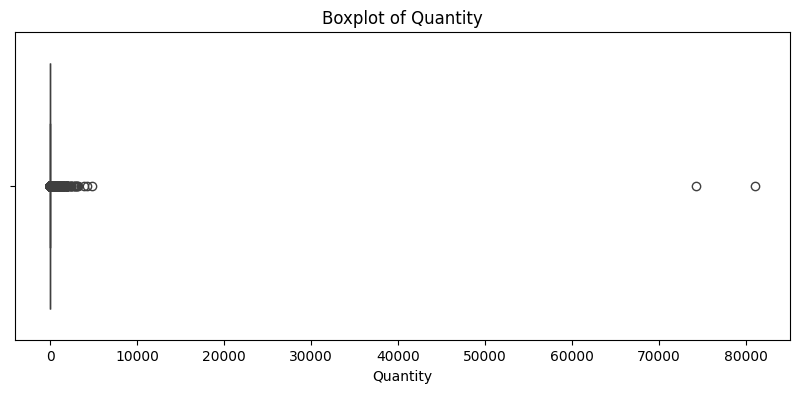

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=ecommerce_retail['Quantity'])
plt.title('Boxplot of Quantity')
plt.show()

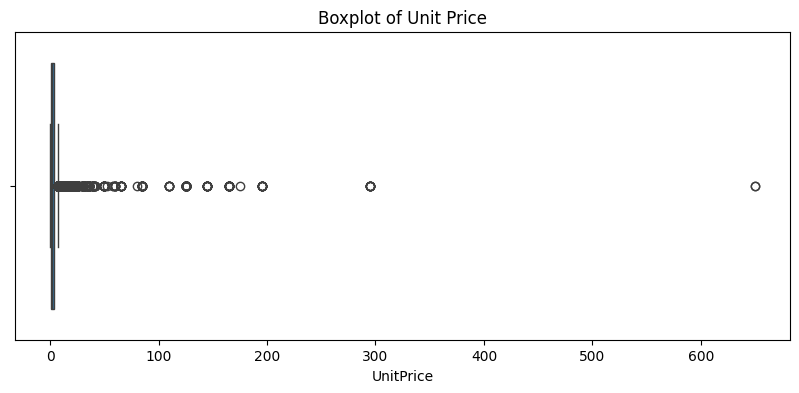

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=ecommerce_retail['UnitPrice'])
plt.title('Boxplot of Unit Price')
plt.show()

In [ ]:
# Phần trăm Outlier của Quantity theo IQR
Q1_quantity = ecommerce_retail['Quantity'].quantile(0.25)
Q3_quantity = ecommerce_retail['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity
lower_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_quantity = Q3_quantity + 1.5 * IQR_quantity
outlier_quantity = ecommerce_retail[(ecommerce_retail['Quantity'] < lower_quantity) | (ecommerce_retail['Quantity'] > upper_quantity)]
outlier_percent_quantity = len(outlier_quantity) / len(ecommerce_retail) * 100
print(f'Outlier Quantity chiếm: {outlier_percent_quantity: .2f}%')

# Phần trăm Outlier của UnitPrice theo IQR
Q1_price = ecommerce_retail['UnitPrice'].quantile(0.25)
Q3_price = ecommerce_retail['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_price = Q1_price - 1.5 * IQR_price
upper_price = Q3_price + 1.5 * IQR_price
outliers_price = ecommerce_retail[(ecommerce_retail['UnitPrice'] < lower_price) | (ecommerce_retail['UnitPrice'] > upper_price)]
outlier_percent_price = len(outliers_price) / len(ecommerce_retail) * 100
print(f'Outlier UnitPrice chiếm: {outlier_percent_price: .2f}%')


Outlier Quantity chiếm:  6.51%
Outlier UnitPrice chiếm:  8.79%


Vì phần trăm Outlier của Quantity và UnitPrice lớn -> cắt theo Percentile 98% của Revenue


In [ ]:
# Tạo cột Revenue
ecommerce_retail['Revenue'] = ecommerce_retail['Quantity'] * ecommerce_retail['UnitPrice']
# Cắt Percentile 98%
threshold_98 = ecommerce_retail['Revenue'].quantile(0.95)
ecommerce_retail_98 = ecommerce_retail[ecommerce_retail['Revenue'] <= threshold_98]

In [ ]:
ecommerce_retail_98.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340980 entries, 1 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    340980 non-null  object        
 1   StockCode    340980 non-null  object        
 2   Description  340980 non-null  object        
 3   Quantity     340980 non-null  int64         
 4   InvoiceDate  340980 non-null  datetime64[ns]
 5   UnitPrice    340980 non-null  float64       
 6   CustomerID   340980 non-null  float64       
 7   Country      340980 non-null  object        
 8   Revenue      340980 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 26.0+ MB


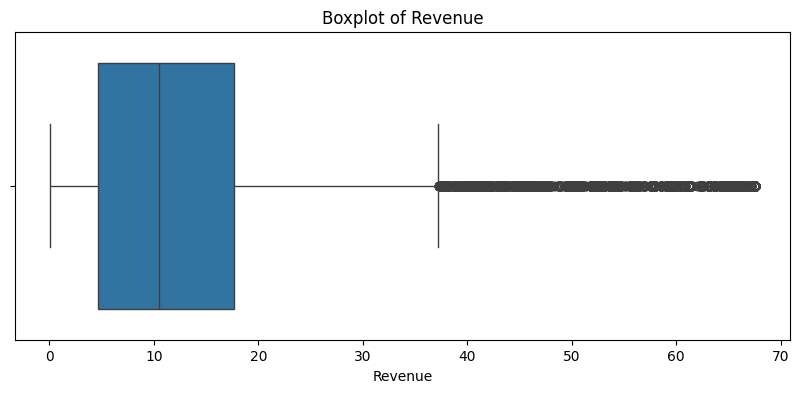

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=ecommerce_retail_98['Revenue'])
plt.title('Boxplot of Revenue')
plt.show()

/tmp/ipython-input-30-2461298205.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = top_ten_country, x = 'Count', y = 'Country', palette = 'Set2' )


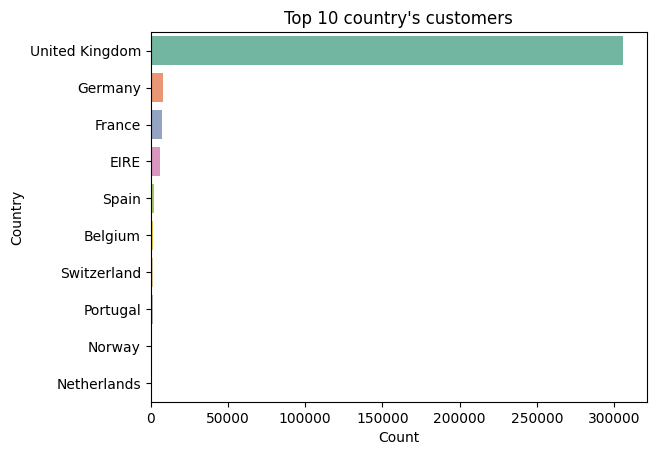

In [ ]:
top_ten_country = ecommerce_retail_98['Country'].value_counts().head(10).reset_index()
top_ten_country.columns = ['Country','Count']
sns.barplot(data = top_ten_country, x = 'Count', y = 'Country', palette = 'Set2' )
plt.title("Top 10 country's customers")
plt.show()

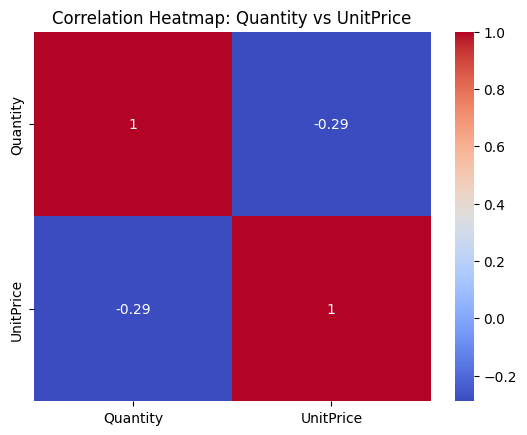

In [ ]:
sns.heatmap(
    ecommerce_retail_98[['Quantity', 'UnitPrice']].corr(),
    annot=True,
    cmap='coolwarm',
)
plt.title('Correlation Heatmap: Quantity vs UnitPrice')
plt.show()


#PART 2: RFM

In [ ]:
snapshot_date = pd.to_datetime('2011-12-31')
ecom_filtered = ecommerce_retail_98[ecommerce_retail_98['InvoiceDate'] <= snapshot_date]
rfm = ecom_filtered.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Revenue': 'sum'
}).reset_index()

rfm.columns = ['CustomerID','Recency', 'Frequency', 'Monetary']


In [ ]:
rfm

,CustomerID,Recency,Frequency,Monetary
0,12347.0,23,158,3143.63
1,12348.0,269,20,683.24
2,12349.0,39,68,1372.42
3,12350.0,331,13,258.00
4,12352.0,57,76,1373.24
...,...,...,...,...
4202,18280.0,298,10,180.60
4203,18281.0,201,7,80.82
4204,18282.0,28,12,178.05
4205,18283.0,24,686,1918.24


In [ ]:
rfm['R_score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['Frequency'], q=5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5])

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score
0,12347.0,23,158,3143.63,5,5,5
1,12348.0,269,20,683.24,1,2,3
2,12349.0,39,68,1372.42,4,4,4
3,12350.0,331,13,258.00,1,2,2
4,12352.0,57,76,1373.24,3,4,4


In [ ]:
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
0,12347.0,23,158,3143.63,5,5,5,555
1,12348.0,269,20,683.24,1,2,3,123
2,12349.0,39,68,1372.42,4,4,4,444
3,12350.0,331,13,258.00,1,2,2,122
4,12352.0,57,76,1373.24,3,4,4,344


In [ ]:
segmentation_data = segmentation_data.rename(columns={"RFM Score": "RFM_score"})
df_segment = segmentation_data.assign(
    RFM_score=segmentation_data['RFM_score'].astype(str).str.split(', ')
).explode('RFM_score')


In [ ]:
df_segment.head()

,Segment,RFM_score
0,Champions,555
0,Champions,554
0,Champions,544
0,Champions,545
0,Champions,454


In [ ]:
rfm_segmented = pd.merge(rfm, df_segment, how ='left', on = 'RFM_score')

In [ ]:
rfm_segmented.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment
0,12347.0,23,158,3143.63,5,5,5,555,Champions
1,12348.0,269,20,683.24,1,2,3,123,Hibernating customers
2,12349.0,39,68,1372.42,4,4,4,444,Loyal
3,12350.0,331,13,258.00,1,2,2,122,Hibernating customers
4,12352.0,57,76,1373.24,3,4,4,344,Loyal


Text(0.5, 1.0, 'Distribution of Recency Score')

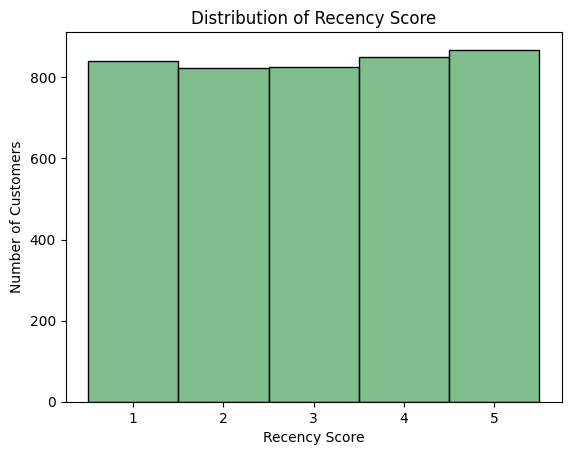

In [ ]:
sns.histplot(rfm_segmented['R_score'], color="#55A868")
plt.xlabel("Recency Score")
plt.ylabel("Number of Customers")
plt.title("Distribution of Recency Score")

Text(0.5, 1.0, 'Distribution of Frequency Score')

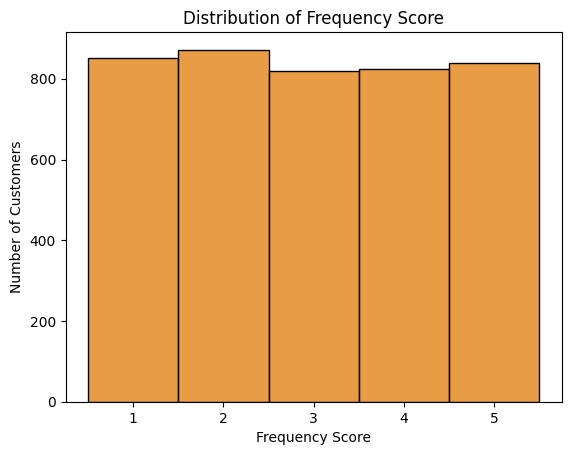

In [ ]:
sns.histplot(rfm_segmented['F_score'], color = '#E17C05')
plt.xlabel("Frequency Score")
plt.ylabel("Number of Customers")
plt.title("Distribution of Frequency Score")

Text(0.5, 1.0, 'Distribution of Monetary Score')

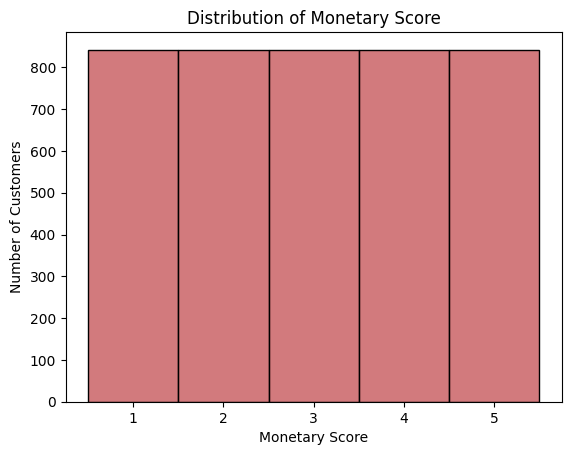

In [ ]:
sns.histplot(rfm_segmented['M_score'], color = '#C44E52')
plt.xlabel("Monetary Score")
plt.ylabel("Number of Customers")
plt.title("Distribution of Monetary Score")

/tmp/ipython-input-45-4166068461.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = sq1, x = 'CustomerID', y = 'Segment', palette = 'Greens_d')


<Axes: xlabel='CustomerID', ylabel='Segment'>

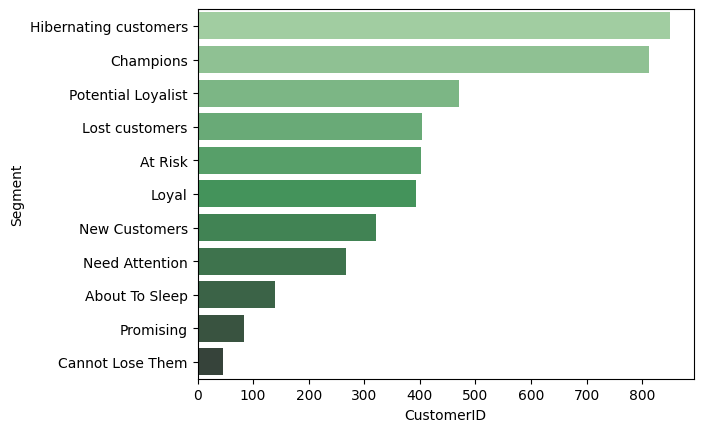

In [ ]:
sq1 = rfm_segmented.groupby('Segment')['CustomerID'].count().sort_values(ascending=False).reset_index()
sns.barplot(data = sq1, x = 'CustomerID', y = 'Segment', palette = 'Greens_d')

In [ ]:
grp = rfm_segmented.groupby('Segment').agg(
    Cust_count=('CustomerID', 'count')
).reset_index()
grp['Count_share'] = grp['Cust_count'] / grp['Cust_count'].sum()
grp

,Segment,Cust_count,Count_share
0,About To Sleep,139,0.033182
1,At Risk,403,0.096204
2,Cannot Lose Them,45,0.010742
3,Champions,813,0.194080
4,Hibernating customers,850,0.202912
5,Lost customers,404,0.096443
6,Loyal,393,0.093817
7,Need Attention,267,0.063738
8,New Customers,321,0.076629
9,Potential Loyalist,470,0.112199


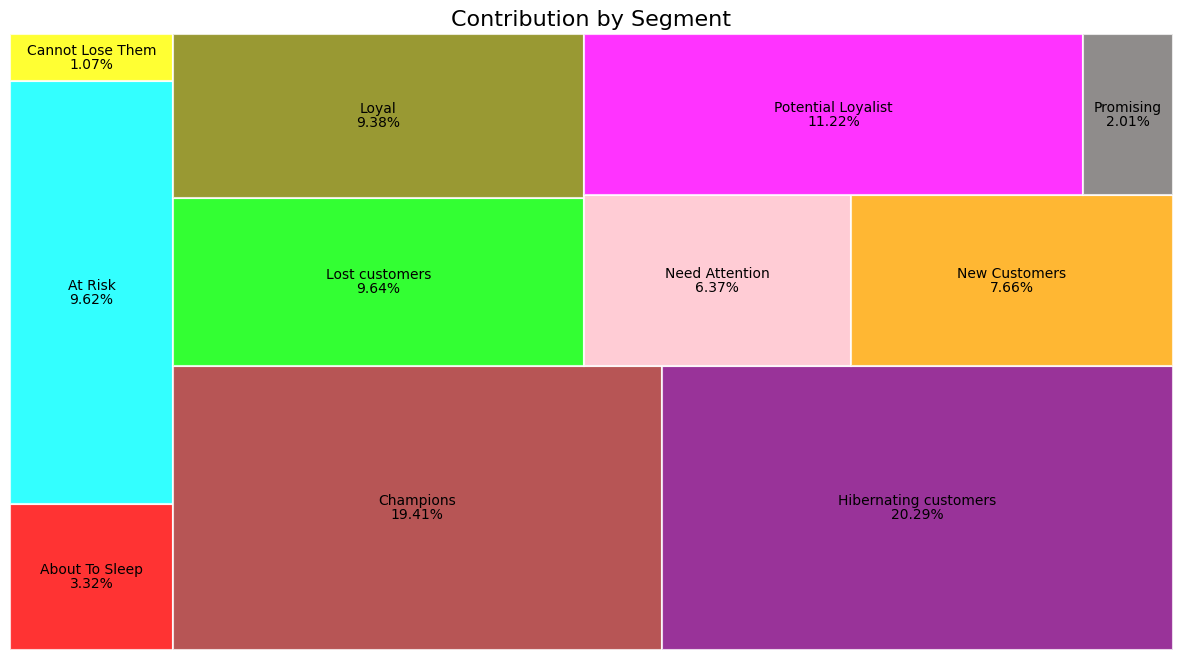

In [ ]:
colors = ['#FF0000', '#00FFFF', '#FFFF00', '#A52A2A', '#800080', '#00FF00', '#808000', '#FFC0CB', '#FFA500', '#FF00FF', '#736F6E']

fig, ax = plt.subplots(1, figsize = (15,8))

squarify.plot(sizes=grp['Cust_count'],
              label=grp['Segment'],
              value=[f'{x*100:.2f}%' for x in grp['Count_share']],
              alpha=.8,
              color=colors,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white")
             )

plt.title('Contribution by SegmentS', fontsize=16)
plt.axis('off')
plt.show()

# Hiện trạng hiện tại của công ty

- Hiện tại công ty có một tệp khách hàng trung thành mạnh gồm Champions + Loyal + Potential xấp xỉ 40% tổng khách. Tuy nhiên cũng có tỷ lệ lớn khách hàng đang rời đi.
- Hệ thống đã có lượng khách hàng mới và tiềm năng gia nhập.
- Các đề xuất bao gồm: duy trì nhóm khách hàng trung thành, kích hoạt lại nhóm 'ngủ đông' hoặc sắp rời đi, chuyển đổi khách mới thành khách trung thành.
- Champions: gửi các chương trình tri ân, ưu đãi độc quyền.
- Loyal: gửi ưu đãi định kì, cá nhân theo lịch sử mua hàng.
Potential Loyalist: tặng mã khuyến mãi cho các lần mua tiếp theo.
- Promising/New Customers: gợi ý các sản phẩm phổ biến, combo khuyến mãi.
- Need Attention/At Risk: gửi các thông báo giảm giá, deal nhanh giới hạn tạo cảm giác FOMO.
- Hibernating/Lost Customers: gửi các thông báo mang tính kỉ niệm + mã hoàn tiền, tặng ưu đãi khi quay trở lại.

# Những điều công ty nên lưu ý với mô hình bán lẻ

Với mô hình bán lẻ đa sản phẩm thì khách hàng có thể quay lại mua nhiều lần với giá trị đơn hàng không quá cao, vòng đời khách hàng dài. Vì vậy công ty nên ưu tiên về chỉ số Frequency, bởi tần suất mua hàng thể hiện rõ nhất mức độ trung thành và giá trị lâu dài của khách hàng.